In [ ]:
#Used Google Colab for creating this script. 
#To run this without errors.Please change path in cells which have this comment: "Includes google drive path"
#All the following packages are needed to run this script without errors

In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

import gensim.models as g


In [2]:
import gensim
print(gensim.__version__)

3.8.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
#Includes google drive path.
#Function: reads csv and prints shape, null values summary column-wise. 
def read_df(df_name):
    df = pd.read_csv('gdrive/My Drive/News Articles Dataset/'+ df_name +'.csv', header = None)
    print('Shape:',df.shape)
    print('Null values')
    print(df.isnull().any())
    return df

In [4]:
df = read_df('train')

Shape: (120000, 3)
Null values
0    False
1    False
2    False
dtype: bool


In [0]:
#Function: renames and combines headline and content
def rename_combine_cols(df, col1, col2, col3, newcol):
    new_df = df.rename(columns = {0:col1, 1:col2, 2:col3})
    new_df[newcol] = new_df[col2] + ' ' + new_df[col3]
    return new_df

In [0]:
df = rename_combine_cols(df, 'class', 'headline', 'content', 'combined')

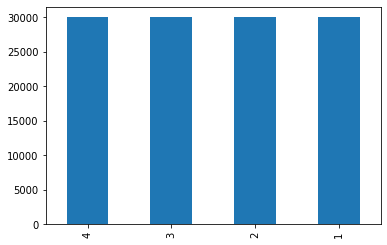

In [8]:
df['class'].value_counts().sort_values().plot(kind = 'bar')

In [9]:
df['class'].value_counts()

4    30000
3    30000
2    30000
1    30000
Name: class, dtype: int64

In [0]:
#Function: removes special characters, punctuations and numbers; tokenize; lemmatize and remove stop words 
def text_preprocess(text):
    text_stripwhitespaces = text.strip()
    text_stripwhitespaces = text_stripwhitespaces.replace("\\", " ")
    text_clean =  re.sub('[~`!@#$%^&*():;"{}_/?><\|.,`0-9]', '', text_stripwhitespaces.replace('-', ' '))
    tokens = word_tokenize(str(text_clean).lower())
    #words = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    words = [word for word in tokens if not word in stop_words]
    if words[0] == words[-1]:
        words.pop(-1)
    final_text = ' '.join(words)
    return final_text

In [0]:
df['combined'] = df['combined'].apply(lambda x: text_preprocess(x))

In [20]:
result = Counter(" ".join(df['combined'].values.tolist()).split(" ")).items()
x = sorted(list(result), key = lambda x: x[1])
print('No.of words occuring more than 100 times:', len([i[1] for i in x if i[1] >= 100]))

No.of words occuring more than 100 times: 4761


In [0]:
text = df['combined'].iloc[:].values

TFIDF Vectorization

In [0]:
vec = TfidfVectorizer(max_features = 5000, ngram_range = (1, 3), max_df = 0.3)

In [0]:
x_train = vec.fit_transform(text).toarray()
y_train = df['class'].iloc[:].values

Preparing Test Data: Treating the test data with same pre-processing steps as train data

In [24]:
df1 = read_df('test')
df1 = rename_combine_cols(df1, 'class', 'headline', 'content', 'combined')
df1['combined'] = df1['combined'].apply(lambda x: text_preprocess(x))
text = df1['combined'].iloc[:].values
x_test = vec.transform(text).toarray()
y_test = df1['class'].iloc[:].values

Shape: (7600, 3)
Null values
0    False
1    False
2    False
dtype: bool


In [0]:
#Function: trains model, predicts on train data and test data, gets training and testing accuracy
def train_fit_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    y_trainpred = model.predict(x_train)
    print('Training Accuracy: ', accuracy_score(y_train, y_trainpred))
    y_testpred = model.predict(x_test)
    score = accuracy_score(y_test, y_testpred)
    print('Training Accuracy: ', accuracy_score(y_test, y_testpred))
    return y_test, y_testpred, model

Naive Bayes Model

In [0]:
model = GaussianNB()

In [27]:
y_test, y_testpred, model = train_fit_predict(model, x_train, y_train, x_test, y_test)

Training Accuracy:  0.8705583333333333
Training Accuracy:  0.8580263157894736


In [0]:
#Function: Prints and plots confusion matrix as heatmap 
def plot_conf_matrix(y, yhat, model):
    conf_matrix = confusion_matrix(y.tolist(), yhat.tolist(), labels=[1,2,3,4])
    print(conf_matrix)
    conf_matrix_df = pd.DataFrame(conf_matrix, range(1,5), range(1,5))
    plt.figure(figsize=(10,7))
    ax = plt.axes()
    sns.heatmap(conf_matrix_df,annot=True,fmt='g',cmap='Blues') # font size
    ax.set_title(str(model))
    plt.show()

[[1526  170  139   65]
 [  30 1843   13   14]
 [  47   70 1582  201]
 [  44   82  204 1570]]


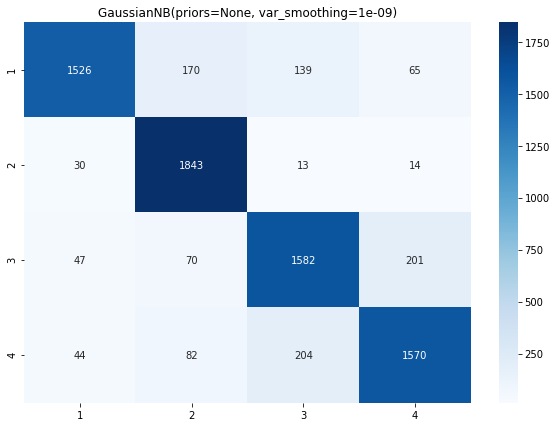

In [29]:
plot_conf_matrix(y_test, y_testpred, model)

Logistic Regression

In [0]:
logr = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)

In [31]:
y_test, y_testpred, model = train_fit_predict(logr, x_train, y_train, x_test, y_test)

[LibLinear]Training Accuracy:  0.9263833333333333
Training Accuracy:  0.9052631578947369


[[1700   60   85   55]
 [  24 1853   12   11]
 [  60   17 1658  165]
 [  66   21  144 1669]]


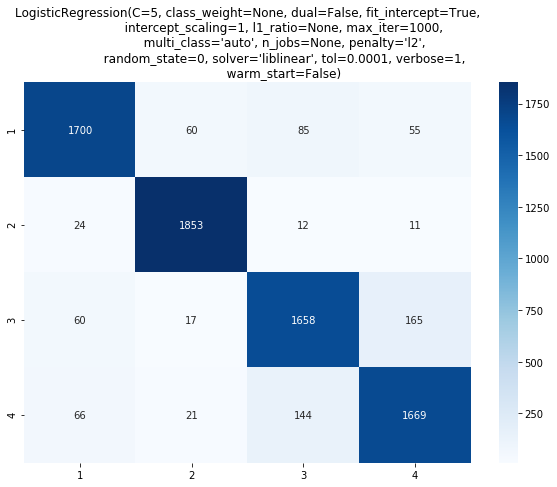

In [32]:
plot_conf_matrix(y_test, y_testpred, logr)

Doc2Vec Vectorization using pre-trained doc2vec model

In [ ]:
#Pre-trained Doc2Vec model trained on Associated Press News articles
#To verify; model has to be downloaded. Download link: https://github.com/jhlau/doc2vec

In [ ]:
#Includes google drive path
d2v_path = 'gdrive/My Drive/doc2vec_pretrained/doc2vec.bin'  

In [33]:
d2v = g.Doc2Vec.load(d2v_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [0]:
#vectorizing train combined text using pre-trained doc2vec model
combinedtext_doc2vec = [d2v.infer_vector(i.split()) for i in df.combined.tolist()] 

In [0]:
x_train_d2v = np.vstack(combinedtext_doc2vec)

In [0]:
np.save('gdrive/My Drive/x_train_d2v.npy', x_train_d2v) 

In [0]:
#vectorizing test combined text using pre-trained doc2vec model
combinedtext_doc2vec1 = [d2v.infer_vector(i.split()) for i in df1.combined.tolist()] 

In [0]:
x_test_d2v = np.vstack(combinedtext_doc2vec1)

In [0]:
np.save('gdrive/My Drive/x_test_d2v.npy', x_test_d2v) 

By vectorizing our text corpus using doc2vec, we have reduced or feature dimensions from 5000 to 300. TFIDF feature vector was a big sparse matrix. But now we have a dense, tightly packed feature vector.

Naive Bayes on Doc2vec features of the news articles

In [0]:
model = GaussianNB()

In [73]:
y_test, y_testpred, model = train_fit_predict(model, x_train_d2v, y_train, x_test_d2v, y_test)

Training Accuracy:  0.8635583333333333
Training Accuracy:  0.8588157894736842


[[1665   73  103   59]
 [  49 1810   27   14]
 [ 110   29 1509  252]
 [  99   39  219 1543]]


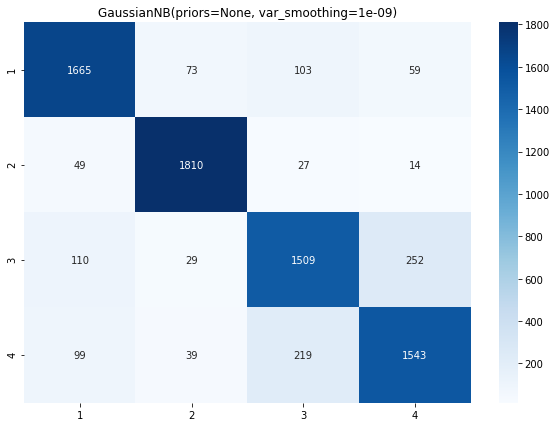

In [74]:
plot_conf_matrix(y_test, y_testpred, model)

Logistic Regression on Doc2vec features of the news articles

In [75]:
y_test, y_testpred, model = train_fit_predict(logr, x_train_d2v, y_train, x_test_d2v, y_test)

[LibLinear]Training Accuracy:  0.8942583333333334
Training Accuracy:  0.8871052631578947


[[1678   61  102   59]
 [  33 1834   22   11]
 [  83   22 1578  217]
 [  56   17  175 1652]]


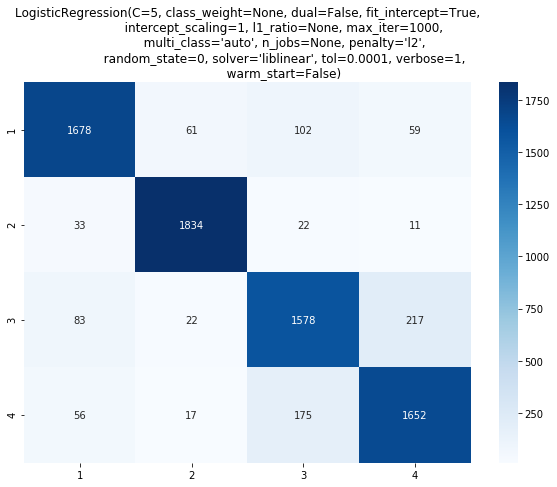

In [76]:
plot_conf_matrix(y_test, y_testpred, logr)

                                                          Summary

![title](img/1.jpg)

![title](img/2.jpg)